## Wavelet Transform.

And now for something completely different (really different).

Wavelet Analysis is now a very common and useful tool for Climate Studies. If you're familiar with the guide made by Torrence and Compo (1998), hereafter TC98, you probably know there's also [software available](http://paos.colorado.edu/research/wavelets/software.html) for different platforms. 

The Python code below, with just a few minor modifications, was provided by Evgenyia Predybaylo and is available at the link above. This particular notebook intends to be more like a 'hands-on' introduction than anything else.

In [1]:
import numpy                 as np
import matplotlib.pylab      as plt
import matplotlib.gridspec   as gridspec
import math
import matplotlib

from waveletFunctions        import*
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
##----- read data
sst_total = np.loadtxt('sst_nino3.dat')

The Niño 3 index above is the one you can download at their website, it's a seasonal index from 1871-2000. From this comes the 'classical' analysis made by TC98 which we will reproduce here.

In [3]:
variance  =  np.std(sst_total, ddof=1) ** 2
stdev     =  np.std(sst_total,ddof=0)   
sst       =  sst_total/ stdev   

It's not necessary to normalize your time series as we did above, but you should do it anyway.

Now comes something a little bit more dangerous.

From the original software provided, we see right next to the normalization one variable named 'lag1', which is the "lag 1 autocorrelation for red noise background". It's defined as 'lag1 = 0.72' but this is valid JUST for the Niño 3 index above, not for other time series you might want to analyse.

TC98 says explicitly that "this red-noise was estimated from $\alpha_{1} + \frac{\sqrt{\alpha_{2}}}{2}$, where $\alpha_{1}$ and $\alpha{2}$ are the lag-1 and lag-2 autocorrelations of the Niño3 SST". So this is NOT a constant value, valid for each and every time series, but one which must be estimated. 

In [4]:
def autocorrelation(x):
    xp = x-np.mean(x)
    f = np.fft.fft(xp)
    p = np.array([np.real(v)**2+np.imag(v)**2 for v in f])
    pi = np.fft.ifft(p)
    return np.real(pi)[:int(x.size/2)]/np.sum(xp**2)

With the above function (got this [here](https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation)) we can calculate the Autocorrelation Function for our data and estimate the 'lag1' variable with it. 

In [5]:
##--- lag-1 autocorrelation for red noise background
acf     =  autocorrelation(sst)
alpha1  =  np.around(acf[1],decimals=2)
alpha2  =  np.around(acf[2],decimals=2)
lagf    =  (alpha1+math.sqrt(alpha2))/2.
lag1    =  np.around(lagf,decimals=2)

print (lag1)

0.72


So you can see that's how we get that somewhat mysterious '0.72' value.

In [6]:
n    =  len(sst)
dt   =  (1/4)
time =  (np.arange(n))*dt + 1871.0   # construct time array
xlim =  ([1871, 2000])               # plotting range
pad  =  1.                           # pad the time series with zeroes (recommended)
dj   =  0.25                         # this will do 4 sub-octaves per octave
s0   =  2 * dt                       # this says start at a scale of 6 months
j1   =  7 / dj                       # this says do 7 powers-of-two with dj sub-octaves each
mother = 'MORLET'                    # options: 'MORLET', 'PAUL' e 'DOG'

In [7]:
##--- Wavelet Transform:
wave, period, scale, coi  = wavelet(sst, dt, pad, dj, s0, j1, mother)
power = (np.abs(wave))  ** 2.        # compute wavelet power spectrum

The 'wavelet' function comes from the 'waveletFunctions.py' script, which is absolutely necessary for our case here (make sure you have it).

In [8]:
##---  Significance levels: (variance=1 for the normalized SST)
signif = wave_signif(([1.00]), dt=dt, sigtest=0, scale=scale, lag1=lag1, mother=mother)
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
sig95 = power / sig95  # where ratio > 1, power is significant

##--- Global wavelet spectrum & significance levels:
global_ws = 1.00 * (np.sum(power, axis=1) / n)  # time-average over all times
dof = n - scale  # the -scale corrects for padding at edges
global_signif = wave_signif(1.00, dt=dt, scale=scale, sigtest=1, lag1=lag1, dof=dof, mother=mother)

##--- Scale-average between El Nino periods of 2--8 years
avg         =  np.logical_and(scale >=2., scale < 8.)
Cdelta      =  0.776  # this is for the MORLET wavelet
scale_avg   =  scale[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand scale --> (J+1)x(N) array
scale_avg   =  power / scale_avg  # [Eqn(24)]
scale_avg   =  1.00 * dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
scaleavg_signif = wave_signif(1.00, dt=dt, scale=scale, sigtest=2, lag1=lag1, dof=([2, 8.]), mother=mother)


So far we have absolutely everything we needed already calculated, easy as that. Of course, many details were left untreated here but if you need more information you can check TC98 (RTFM).

The original software makes no use of Matplotlib's [Gridspec](https://matplotlib.org/users/gridspec.html) function, but it is a very useful tool to manage subplots and you should take a look at it. It can really make your life easier.

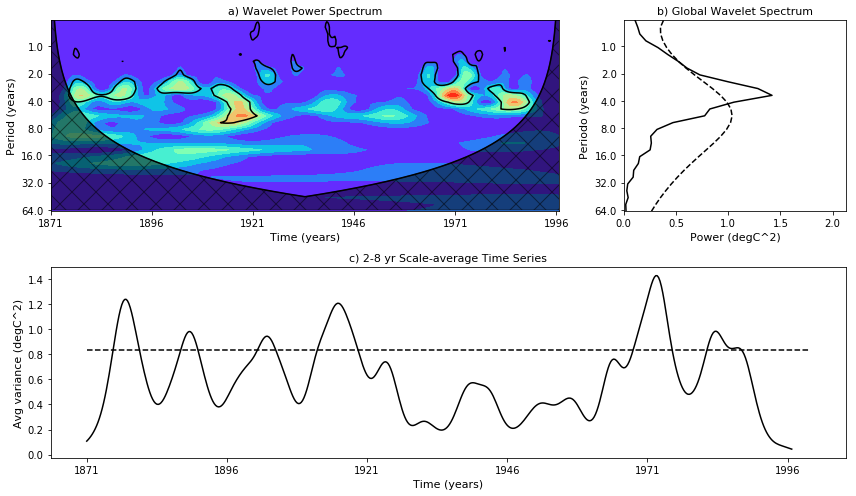

In [13]:
gs = gridspec.GridSpec(2, 3)


##----- a) Contour plot wavelet power spectrum
plt.figure(figsize=(12,7))
plt3  = plt.subplot(gs[0,0:2])
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
CS = plt.contourf(time, period, power, len(levels))  #*** or use 'contour'
#im = plt.contourf(CS, cmap='binary',vmin=1.0,vmax=8.) # more contour options
im  =  plt.contourf(CS, cmap='rainbow')
plt.xlabel('Time (years)',fontsize=11)
plt.ylabel('Period (years)',fontsize=11)
plt.title('a) Wavelet Power Spectrum',fontsize=11)
plt.xticks(range(1871, 2005, 25))

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
plt.contour(time, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.plot(time, coi, 'k')

# 'x' fill under cone of influence area
ts = time
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]])
plt.fill(ts_area,(coi_area),color='Black',alpha=0.5,hatch="x")

# format y-scale
plt3.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
plt3.invert_yaxis()

# set up the size and location of the colorbar
#divider = make_axes_locatable(plt3)
#cax = divider.append_axes("bottom", size="5%", pad=0.5)
#plt.colorbar(im, cax=cax, orientation='horizontal')



##--- b) global wavelet spectrum
plt4  = plt.subplot(gs[0,2])
plt.plot(global_ws, period, 'black')
plt.plot(global_signif,period, 'k--')
plt.xlabel('Power (degC^2)',fontsize=11)
plt.ylabel('Periodo (years)',fontsize=11)
plt.title('b) Global Wavelet Spectrum',fontsize=11)
plt.xlim([0, 1.5 * np.max(global_ws)])
plt4.set_yscale('log', basey=2, subsy=None)
pmin = np.min(period)
pmax = np.max(period)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()



##--- c) 2--8 yr scale-average time series
plt.subplot(gs[1,:])
plt.plot(time, scale_avg, 'black')
plt.xticks(range(1871, 2005, 25))
plt.xlabel('Time (years)',fontsize=11)
plt.ylabel('Avg variance (degC^2)',fontsize=11)
plt.title('c) 2-8 yr Scale-average Time Series',fontsize=11)
plt.plot(xlim, scaleavg_signif + [0, 0], 'k--')



plt.tight_layout()
plt.show()

Above is the classic TC98 analysis for the Niño 3 Index. You will probably notice the lack of the time series plot, but you can easily do that with Gridspec and a little bit of imagination (exercise left for the reader). The model, so to speak, for the plot is the one you can see on Andreoli and Kayano (2004) paper, but feel free to make it as pretty as you like.

Another thing.

The Wavelet Analysis is not a perfect method, and it certainly has some problems to consider. The work of Liu et al. (2007) proposes an interesting discussion as well as a 'rectification' of the Power Spectrum.

They also made available a [Matlab code](http://ocgweb.marine.usf.edu/~liu/wavelet.html) for the rectification mentioned above, which can be easily 'translated' for our Python code. That is:

In [10]:
powers      =   np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:] / scale[k]


global_ws      =   global_ws / scale
global_signif  =   global_signif  / scale

What is the effect of that? We shall see now.

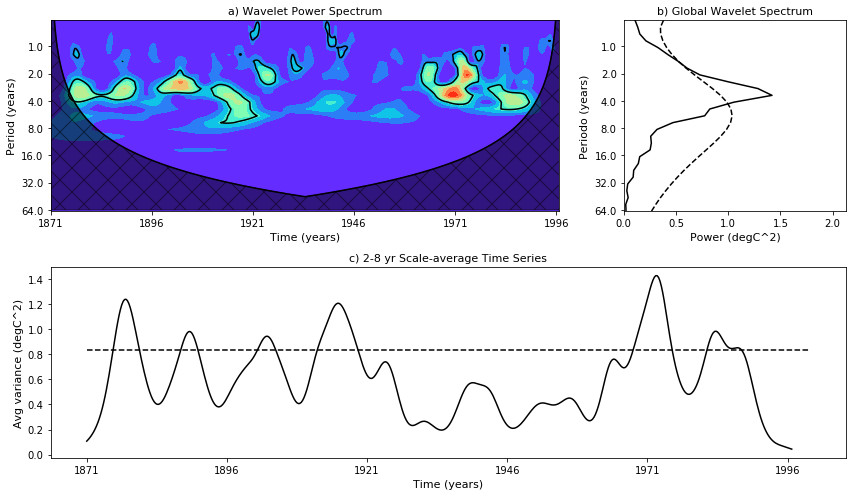

In [12]:
gs = gridspec.GridSpec(2, 3)


##----- a) Contour plot wavelet power spectrum
plt.figure(figsize=(12,7))
plt3  = plt.subplot(gs[0,0:2])
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
CS = plt.contourf(time, period, powers, len(levels))  #*** or use 'contour'
#im = plt.contourf(CS, cmap='binary',vmin=1.0,vmax=8.) # more contour options
im  =  plt.contourf(CS, cmap='rainbow')
plt.xlabel('Time (years)',fontsize=11)
plt.ylabel('Period (years)',fontsize=11)
plt.title('a) Wavelet Power Spectrum',fontsize=11)
plt.xticks(range(1871, 2005, 25))

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
plt.contour(time, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.plot(time, coi, 'k')

# 'x' fill under cone of influence area
ts = time
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]])
plt.fill(ts_area,(coi_area),color='Black',alpha=0.5,hatch="x")

# format y-scale
plt3.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
plt3.invert_yaxis()

# set up the size and location of the colorbar
#divider = make_axes_locatable(plt3)
#cax = divider.append_axes("bottom", size="5%", pad=0.5)
#plt.colorbar(im, cax=cax, orientation='horizontal')


##--- b) global wavelet spectrum
plt4  = plt.subplot(gs[0,2])
plt.plot(global_ws, period, 'black')
plt.plot(global_signif,period, 'k--')
plt.xlabel('Power (degC^2)',fontsize=11)
plt.ylabel('Periodo (years)',fontsize=11)
plt.title('b) Global Wavelet Spectrum',fontsize=11)
plt.xlim([0, 1.5 * np.max(global_ws)])
plt4.set_yscale('log', basey=2, subsy=None)
pmin = np.min(period)
pmax = np.max(period)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()


##--- c) 2--8 yr scale-average time series
plt.subplot(gs[1,:])
plt.plot(time, scale_avg, 'black')
plt.xticks(range(1871, 2005, 25))
plt.xlabel('Time (years)',fontsize=11)
plt.ylabel('Avg variance (degC^2)',fontsize=11)
plt.title('c) 2-8 yr Scale-average Time Series',fontsize=11)
plt.plot(xlim, scaleavg_signif + [0, 0], 'k--')


plt.tight_layout()
plt.show()

The Power Spectrum is not very different from the original TC98 plot, but we can see a sharp difference for the Rectified Global Spectrum.

Apart from discussions and more polemics, I guess we can see how easy is to perform a Wavelet Analysis for our data. 

The purpose of this notebook was merely to show how simple things can be, but if you need more information you should definitely check the Wavelet Literature as there are tons of things written about it. Hope this one can be useful as well!

The code was provided by Evgenyia Predybaylo but you can check at the [repository](https://github.com/willyhagi/climate-statistics) the same code with some changes, like the option for the Rectified Bias, as they are also made to be compatible with Python 3.6 since the original one is not. Feel free to make modifications or anything you might want to do.

## REFERENCES

1 - Torrence, Christopher, and Gilbert P. Compo. "A practical guide to wavelet analysis." Bulletin of the American Meteorological society 79.1 (1998): 61-78.

2 - Andreoli, Rita Valéria, and Mary Toshie Kayano. "Multi‐scale variability of the sea surface temperature in the Tropical Atlantic." Journal of Geophysical Research: Oceans 109.C5 (2004).

3 - Liu, Yonggang, X. San Liang, and Robert H. Weisberg. "Rectification of the bias in the wavelet power spectrum." Journal of Atmospheric and Oceanic Technology 24.12 (2007): 2093-2102.